In [1]:
import pandas as pd

df = pd.read_csv('archive\SPAM text message 20170820 - Data.csv')
df = df[['Category','Message']]
size = df.shape[0]
df.index = range(size)
total_word_count = df['Message'].apply(lambda x : len(x.split(' '))).sum()

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Category_encoded'] = le.fit_transform(df['Category'])

import re
def cleantext(text):
    text = re.sub(r"http\S+",r'<URL>',text )
    text = text.lower()
    
    return text

df['Message'] = df['Message'].apply(cleantext)

df = df.drop(columns=['Category'])

from tensorflow.keras.preprocessing.text import Tokenizer
import math
max_vocab_size = math.floor(total_word_count*0.15)

tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<oov>" , filters='!@#$%^&*()_+{;}|:"<>?', lower=True)

tokenizer.fit_on_texts(df['Message'])

sequences = tokenizer.texts_to_sequences(df['Message'])

vocabulary_size = len(tokenizer.word_index) +1

from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 100
X = pad_sequences(sequences,
                  maxlen = max_length,
                  padding = 'post',
                  truncating='post')

y = df['Category_encoded'].values


from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(
    X,y,test_size=0.2,random_state=42
)

# Print split info
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"Training spam ratio: {y_train.mean():.3f}")
print(f"Testing spam ratio: {y_test.mean():.3f}")

Training samples: 4457
Testing samples: 1115
Training spam ratio: 0.134
Testing spam ratio: 0.134


In [4]:
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, SpatialDropout1D, Flatten
from tensorflow.keras import Input
from tensorflow.keras.models import load_model, Model, Sequential
from attention import Attention
import tensorflow as tf

embedding_dim = 128
lstm_units = 64

inputs = Input(shape=(max_length,))
        
embedding = Embedding(input_dim = min(vocabulary_size,max_vocab_size),
                    output_dim = embedding_dim,
                    input_length = max_length)(inputs)
embedding = SpatialDropout1D(0.2)(embedding)

lstm_out = LSTM(lstm_units, return_sequences=True, dropout=0.2,
               recurrent_dropout=0.2, 
              )(embedding)
lstm_out2 = LSTM(lstm_units//2, return_sequences =True, dropout = 0.2, recurrent_dropout =  0.2)(lstm_out)

# # Attention mechanism

# attention = tf.keras.layers.Activation('softmax')(lstm_out2)
# attention = tf.keras.layers.RepeatVector(lstm_units//2)(attention)
# attention = tf.keras.layers.Permute([2, 1])(attention)

# sent_representation = tf.keras.layers.multiply([lstm_out2, attention])
# sent_representation = tf.keras.layers.Lambda(
#     lambda x: tf.keras.backend.sum(x, axis=1)
# )(sent_representation)

def attention_layer(inputs):
    # inputs shape: (batch_size, time_steps, features)
    attention_weights = tf.nn.softmax(tf.reduce_sum(inputs, axis=-1, keepdims=True), axis=1)
    # attention_weights shape: (batch_size, time_steps, 1)
    
    weighted_input = inputs * attention_weights
    # weighted_input shape: (batch_size, time_steps, features)
    
    output = tf.reduce_sum(weighted_input, axis=1)
    # output shape: (batch_size, features)
    return output

sent_representation = tf.keras.layers.Lambda(attention_layer)(lstm_out2)

dense = Dense(32, activation='relu')(sent_representation)
dense = Dropout(0.2)(dense)
outputs = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

print(model.summary())
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0, # minimum change in the monitored quality to qualify as improvement
    patience = 10, # number of epochs with no improvements after which training will be stopped
    verbose = 1, #1 displays the message when the callback takes an action
    mode = 'auto',
    #One of {"auto", "min", "max"}.
    # In min mode, training will stop when the quantity monitored has stopped decreasing;
    # in "max" mode it will stop when the quantity monitored has stopped increasing;
    #in "auto" mode, the direction is automatically inferred from the name of the monitored quantity. Defaults to "auto".
    restore_best_weights =True
)
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2, #factor by which the learning rate will be reduced lr*factor
    patience =5, #num,ber of epochs with no improvement after which learning rate will be reduced
    verbose = 1, # for updaing the messages
    mode = 'auto',
    min_lr = 0.001 #lowerbound for learning rate
    
    
)

callbacks = [early_stopping,reduce_lr]

print("\nStarting training...")
batch_size = 32
epochs = 50

history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)



C:\Users\Bachu Sai Raj\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 100, 128)       │     1,541,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ (None, 100, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 100, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,604,673 (6.12 MB)

 Trainable params: 1,604,673 (6.12 MB)

 Non-trainable params: 0 (0.00 B)

None

Starting training...
Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.9253 - loss: 0.2206 - val_accuracy: 0.9785 - val_loss: 0.0719 - learning_rate: 0.0010
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.9901 - loss: 0.0429 - val_accuracy: 0.9857 - val_loss: 0.0539 - learning_rate: 0.0010
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.9962 - loss: 0.0189 - val_accuracy: 0.9848 - val_loss: 0.0561 - learning_rate: 0.0010
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.9982 - loss: 0.0094 - val_accuracy: 0.9892 - val_loss: 0.0544 - learning_rate: 0.0010
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - accuracy: 0.9978 - loss: 0.0071 - val_accuracy: 0.9857 - val_loss: 0.0594 - learning_rate: 0.0010
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.9998 - loss: 0.0023 - val_accuracy: 0.9857 - val_loss: 0.0526 - learning_rate: 0.0010
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/

In [6]:
# Save the trained model
model.save('lstm_2_layer_model.h5')
print("Model saved as 'lstm_2_layer_model.h5'")

model_json = model.to_json()
with open("lstm_2_layer_model_architecture.json", "w") as json_file:
    json_file.write(model_json)
print("Model architecture saved as JSON")

# Save only the weights (optional)
model.save_weights('lstm_2_layer_model.weights.h5')
print("Model weights saved")

Model saved as 'lstm_2_layer_model.h5'
Model architecture saved as JSON
Model weights saved


Getting predictions...
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step

BASIC CLASSIFICATION METRICS
Test Accuracy:  0.9892
Test Precision: 0.9660
Test Recall:    0.9530
Test F1-Score:  0.9595

Train Accuracy:  1.0000
Train Precision: 1.0000
Train Recall:    1.0000
Train F1-Score:  1.0000

DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Class 0       0.99      0.99      0.99       966
     Class 1       0.97      0.95      0.96       149

    accuracy                           0.99      1115
   macro avg       0.98      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115


CONFUSION MATRIX
Confusion Matrix:
[[961   5]
 [  7 142]]

True Negatives:  961
False Positives: 5
False Negatives: 7
True Positives:  142

Specificity (True Negative Rate): 0.9948
Sensitivity (True Positive Rate): 0.9530

ROC-AUC METRICS
ROC-AUC Score: 0.9945

PRECISION-RECALL METRICS
Average Precision Score: 0.98

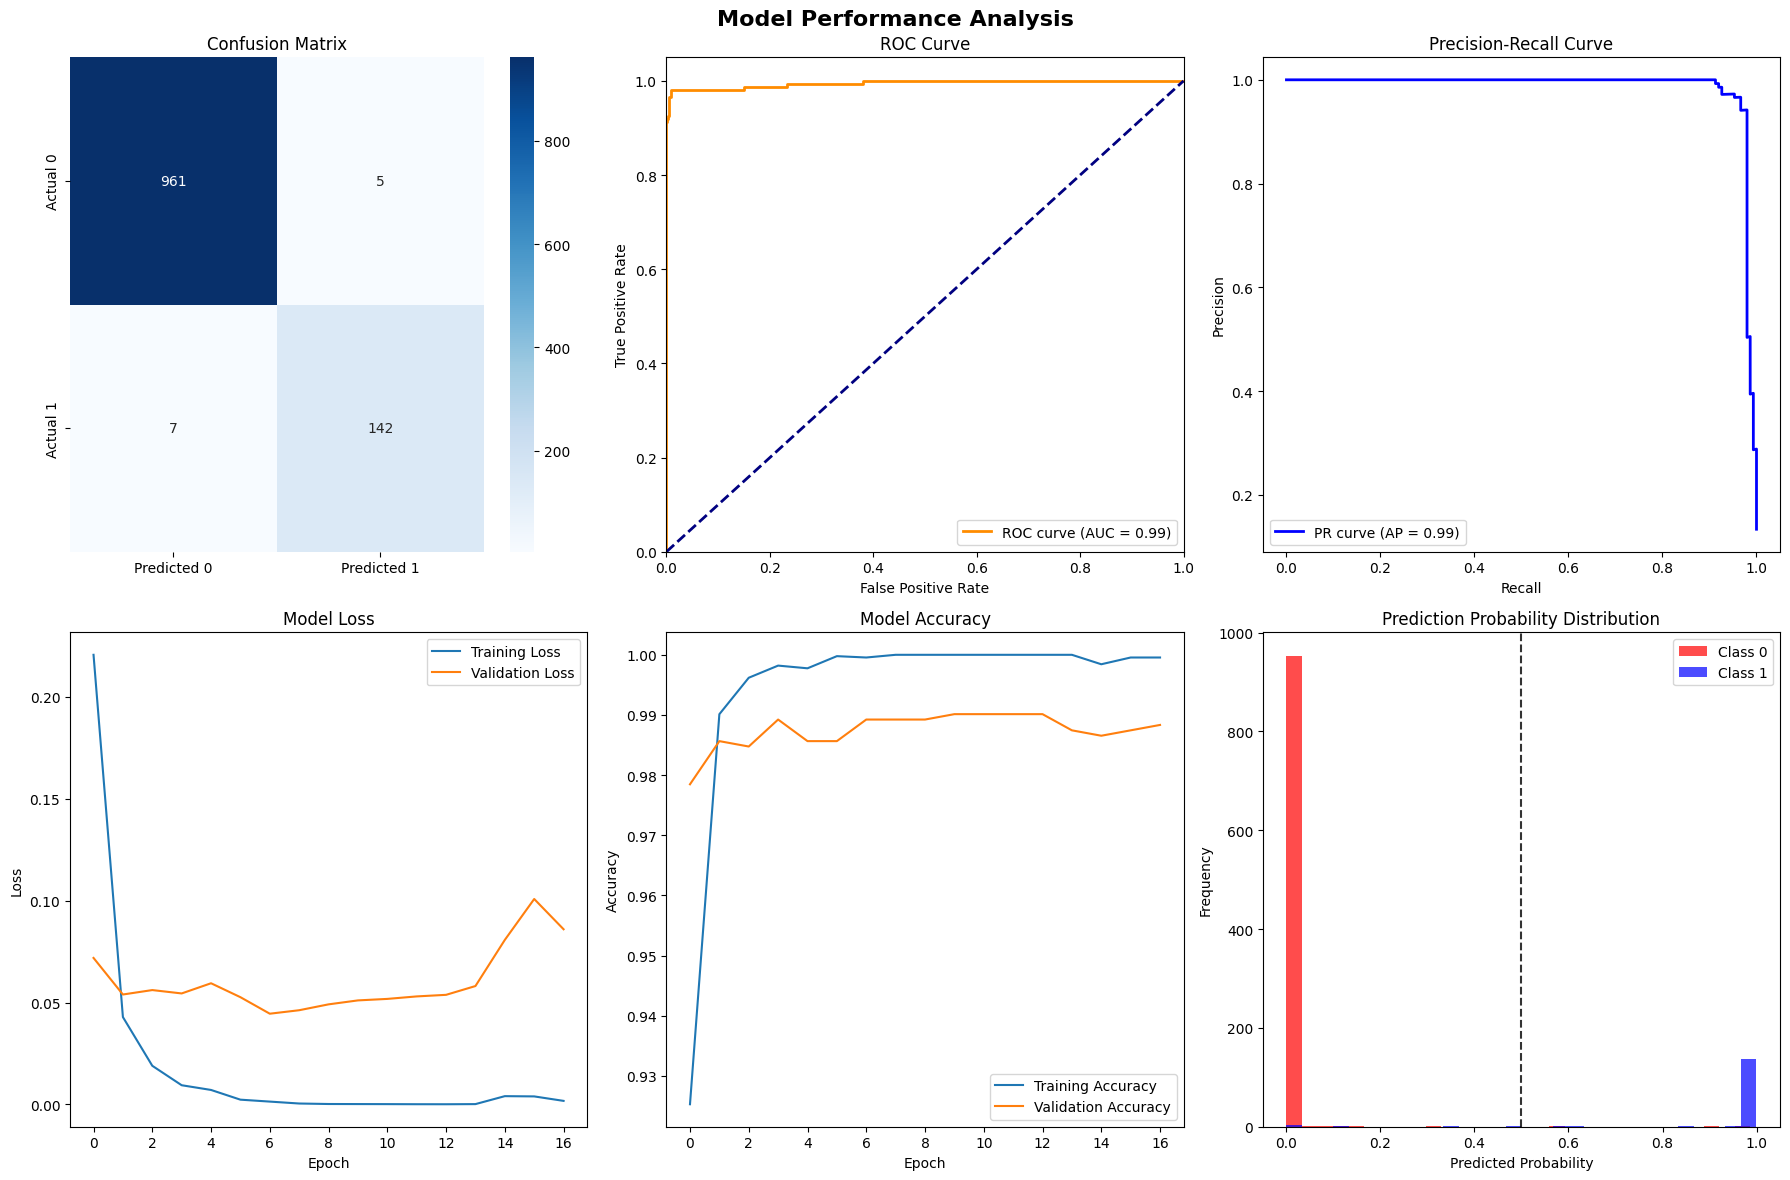


METRICS SUMMARY TABLE
        Metric  Test Score Train Score
0     Accuracy      0.9892         1.0
1    Precision      0.9660         1.0
2       Recall      0.9530         1.0
3     F1-Score      0.9595         1.0
4  Specificity      0.9948    0.994824
5      ROC-AUC      0.9945         N/A
6       PR-AUC      0.9857         N/A

SAVING RESULTS...
✅ Metrics saved to 'model_metrics_report.txt'
✅ All calculations completed!


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
import tensorflow as tf

# 1. GET PREDICTIONS
print("Getting predictions...")
y_pred_prob = model.predict(X_test)  # Probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Binary predictions

# Also get training predictions for comparison
y_train_pred_prob = model.predict(X_train)
y_train_pred = (y_train_pred_prob > 0.5).astype(int)

# 2. BASIC METRICS
print("\n" + "="*50)
print("BASIC CLASSIFICATION METRICS")
print("="*50)

# Test set metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

print(f"Test Accuracy:  {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")
print(f"Test F1-Score:  {test_f1:.4f}")

# Training set metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

print(f"\nTrain Accuracy:  {train_accuracy:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Train Recall:    {train_recall:.4f}")
print(f"Train F1-Score:  {train_f1:.4f}")

# 3. DETAILED CLASSIFICATION REPORT
print("\n" + "="*50)
print("DETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

# 4. CONFUSION MATRIX
print("\n" + "="*50)
print("CONFUSION MATRIX")
print("="*50)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Calculate additional metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives:  {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives:  {tp}")

# Specificity and other metrics
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)  # Same as recall
print(f"\nSpecificity (True Negative Rate): {specificity:.4f}")
print(f"Sensitivity (True Positive Rate): {sensitivity:.4f}")

# 5. ROC-AUC METRICS
print("\n" + "="*50)
print("ROC-AUC METRICS")
print("="*50)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# 6. PRECISION-RECALL METRICS
print("\n" + "="*50)
print("PRECISION-RECALL METRICS")
print("="*50)

# Calculate Precision-Recall curve
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, y_pred_prob)
avg_precision = average_precision_score(y_test, y_pred_prob)
print(f"Average Precision Score: {avg_precision:.4f}")

# 7. TRAINING HISTORY ANALYSIS
print("\n" + "="*50)
print("TRAINING HISTORY ANALYSIS")
print("="*50)

if 'history' in locals():
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    
    print(f"Final Training Loss:     {final_train_loss:.4f}")
    print(f"Final Validation Loss:   {final_val_loss:.4f}")
    print(f"Final Training Accuracy: {final_train_acc:.4f}")
    print(f"Final Validation Accuracy: {final_val_acc:.4f}")
    
    # Check for overfitting
    loss_diff = abs(final_train_loss - final_val_loss)
    acc_diff = abs(final_train_acc - final_val_acc)
    
    print(f"\nLoss Difference (Train-Val): {loss_diff:.4f}")
    print(f"Accuracy Difference (Train-Val): {acc_diff:.4f}")
    
    if loss_diff > 0.1 or acc_diff > 0.05:
        print("⚠️  Potential overfitting detected!")
    else:
        print("✅ No significant overfitting detected.")

# 8. VISUALIZATION
print("\n" + "="*50)
print("GENERATING VISUALIZATIONS...")
print("="*50)

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Model Performance Analysis', fontsize=16, fontweight='bold')

# Plot 1: Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Predicted 0', 'Predicted 1'],
           yticklabels=['Actual 0', 'Actual 1'], ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix')

# Plot 2: ROC Curve
axes[0,1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve')
axes[0,1].legend(loc="lower right")

# Plot 3: Precision-Recall Curve
axes[0,2].plot(recall_curve, precision_curve, color='blue', lw=2, 
              label=f'PR curve (AP = {avg_precision:.2f})')
axes[0,2].set_xlabel('Recall')
axes[0,2].set_ylabel('Precision')
axes[0,2].set_title('Precision-Recall Curve')
axes[0,2].legend(loc="lower left")

# Plot 4: Training History - Loss
if 'history' in locals():
    axes[1,0].plot(history.history['loss'], label='Training Loss')
    axes[1,0].plot(history.history['val_loss'], label='Validation Loss')
    axes[1,0].set_title('Model Loss')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Loss')
    axes[1,0].legend()

# Plot 5: Training History - Accuracy
if 'history' in locals():
    axes[1,1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[1,1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[1,1].set_title('Model Accuracy')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].set_ylabel('Accuracy')
    axes[1,1].legend()

# Plot 6: Prediction Distribution
axes[1,2].hist(y_pred_prob[y_test==0], bins=30, alpha=0.7, label='Class 0', color='red')
axes[1,2].hist(y_pred_prob[y_test==1], bins=30, alpha=0.7, label='Class 1', color='blue')
axes[1,2].set_xlabel('Predicted Probability')
axes[1,2].set_ylabel('Frequency')
axes[1,2].set_title('Prediction Probability Distribution')
axes[1,2].legend()
axes[1,2].axvline(x=0.5, color='black', linestyle='--', alpha=0.8, label='Threshold')

plt.tight_layout()
plt.show()

# 9. METRICS SUMMARY TABLE
print("\n" + "="*50)
print("METRICS SUMMARY TABLE")
print("="*50)

metrics_summary = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Specificity', 'ROC-AUC', 'PR-AUC'],
    'Test Score': [test_accuracy, test_precision, test_recall, test_f1, specificity, roc_auc, avg_precision],
    'Train Score': [train_accuracy, train_precision, train_recall, train_f1, 
                   tn/(tn+fp) if 'tn' in locals() else 'N/A', 'N/A', 'N/A']
}

import pandas as pd
df_metrics = pd.DataFrame(metrics_summary)
print(df_metrics.round(4))

# 10. SAVE RESULTS
print("\n" + "="*50)
print("SAVING RESULTS...")
print("="*50)

# Save metrics to file
with open('model_metrics_report.txt', 'w') as f:
    f.write("MODEL PERFORMANCE REPORT\n")
    f.write("="*50 + "\n\n")
    f.write(f"Test Accuracy: {test_accuracy:.4f}\n")
    f.write(f"Test Precision: {test_precision:.4f}\n")
    f.write(f"Test Recall: {test_recall:.4f}\n")
    f.write(f"Test F1-Score: {test_f1:.4f}\n")
    f.write(f"ROC-AUC: {roc_auc:.4f}\n")
    f.write(f"PR-AUC: {avg_precision:.4f}\n\n")
    f.write("Confusion Matrix:\n")
    f.write(str(cm) + "\n\n")
    f.write("Classification Report:\n")
    f.write(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

print("✅ Metrics saved to 'model_metrics_report.txt'")
print("✅ All calculations completed!")

🔍 IMPROVED LIME EXPLAINABILITY ANALYSIS FOR MISCLASSIFIED OBSERVATIONS

📊 Step 1: Identifying Misclassified Samples...
Total misclassified samples: 12
False Positives (Predicted 1, Actual 0): 5
False Negatives (Predicted 0, Actual 1): 7
False Positive indices: [np.int64(116), np.int64(204), np.int64(359), np.int64(707), np.int64(971)]
False Negative indices: [np.int64(234), np.int64(272), np.int64(324), np.int64(550), np.int64(635), np.int64(795), np.int64(1081)]

🔤 Step 2: Creating Text Representation...
Creating pseudo-text representations...
Created 1115 pseudo-text samples

🎯 Step 3: Creating Enhanced Model Wrapper...

🧪 Step 4: Testing Wrapper Functionality...
Test text: common_word_40 common_word_9 common_word_30 common_word_7 common_word_11 rare_word_400 common_word_1...
Test prediction shape: (1, 2)
Test prediction: [9.998883e-01 1.116976e-04]
✅ Wrapper working correctly!

🧠 Step 5: Initializing LIME Explainer...
✅ LIME explainer initialized successfully!

🔬 Step 6: Analyzing M

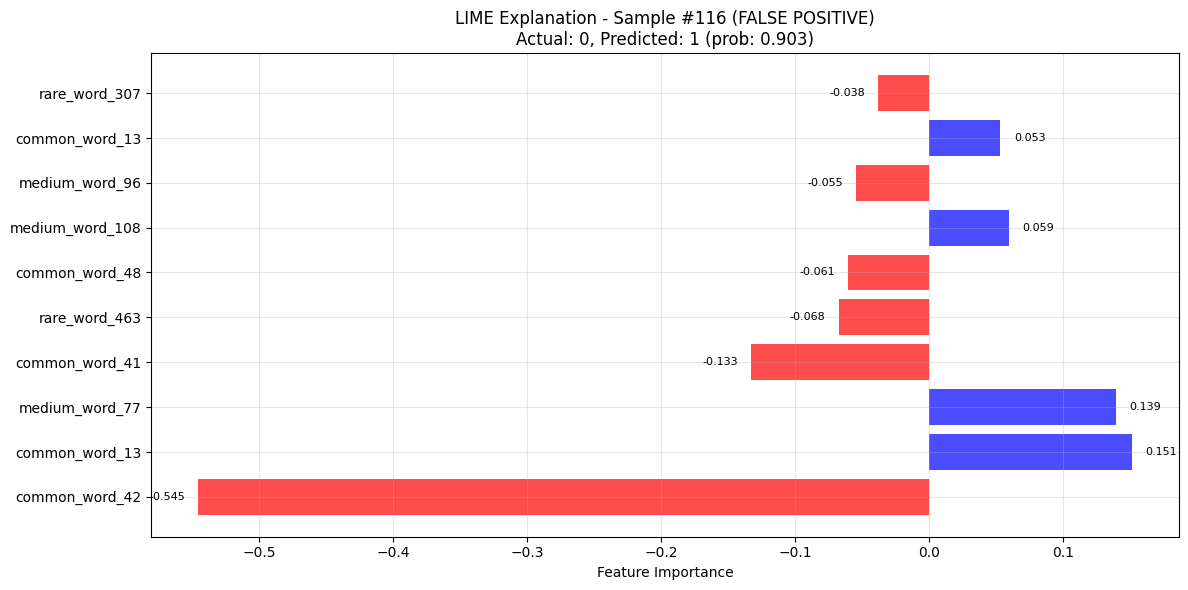


SAMPLE #204 - FALSE POSITIVE
Actual Label: 0
Predicted Probability: 0.5894
Predicted Label: 1
Text Preview: common_word_4 rare_word_467 rare_word_271 medium_word_195 common_word_9 medium_word_51 common_word_39 rare_word_879 common_word_39 medium_word_79 common_word_27...
Model prediction check: [0.9984242  0.00157585]
Generating LIME explanation...

🔍 Top Features Contributing to Prediction:
--------------------------------------------------
 1. 'rare_word_271' | -0.3570 → Class_0
 2. 'medium_word_195' | +0.2867 → Class_1
 3. 'medium_word_51' | -0.0990 → Class_0
 4. 'rare_word_879' | -0.0863 → Class_0
 5. 'common_word_39' | -0.0559 → Class_0
 6. 'common_word_9' | -0.0524 → Class_0
 7. 'rare_word_467' | +0.0257 → Class_1
 8. 'common_word_27' | -0.0239 → Class_0


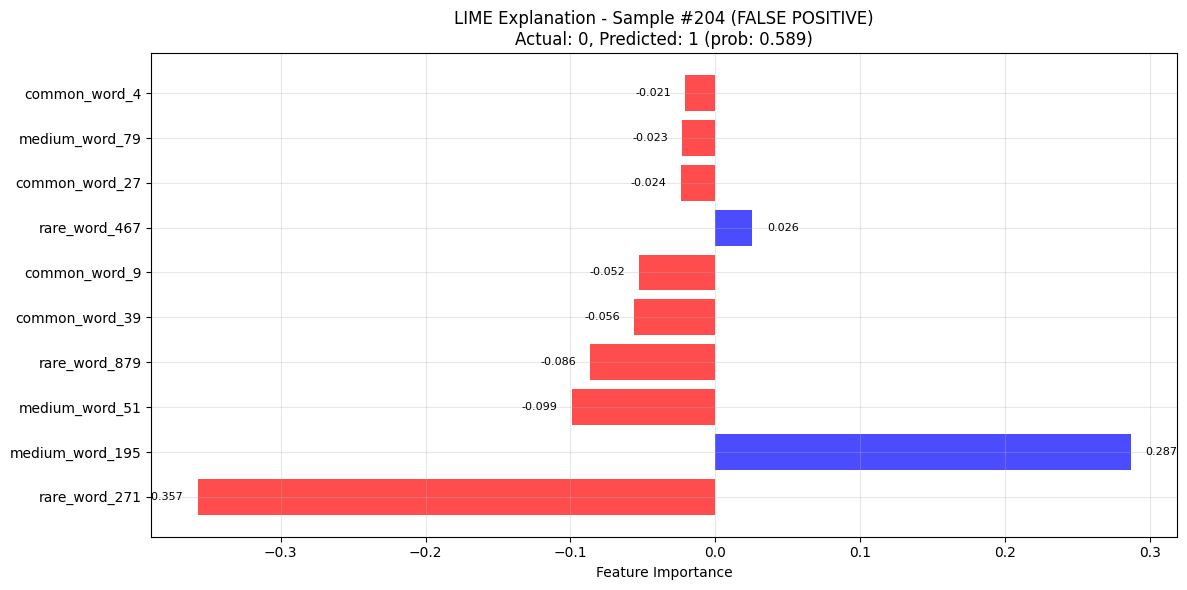


SAMPLE #359 - FALSE POSITIVE
Actual Label: 0
Predicted Probability: 0.9573
Predicted Label: 1
Text Preview: common_word_39 common_word_20 common_word_3 common_word_21 common_word_13 common_word_12 common_word_9 common_word_13 common_word_35 rare_word_598 rare_word_837 medium_word_184...
Model prediction check: [0.95223916 0.04776084]
Generating LIME explanation...

🔍 Top Features Contributing to Prediction:
--------------------------------------------------
 1. 'common_word_21' | -0.4826 → Class_0
 2. 'rare_word_598' | -0.3608 → Class_0
 3. 'common_word_13' | +0.2748 → Class_1
 4. 'rare_word_837' | +0.2367 → Class_1
 5. 'common_word_13' | +0.2221 → Class_1
 6. 'common_word_39' | -0.1718 → Class_0
 7. 'common_word_35' | -0.0804 → Class_0
 8. 'common_word_20' | -0.0794 → Class_0


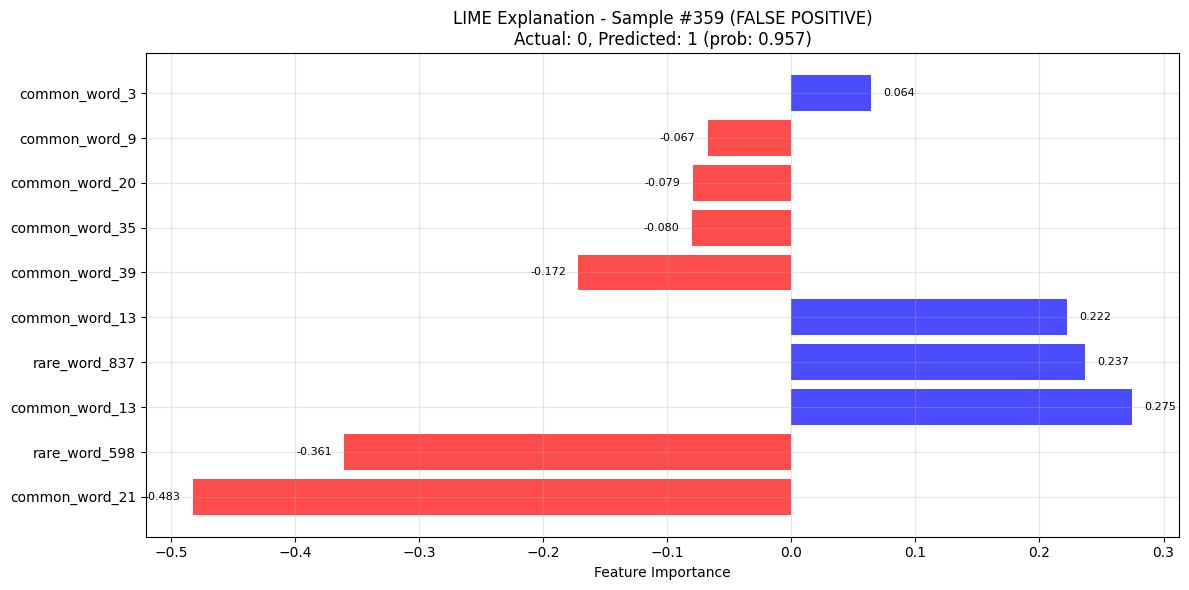


🔵 ANALYZING FALSE NEGATIVES (Model predicted 0, Actual 1)

SAMPLE #234 - FALSE NEGATIVE
Actual Label: 1
Predicted Probability: 0.0001
Predicted Label: 0
Text Preview: rare_word_323 common_word_50 common_word_20 common_word_4 medium_word_120 common_word_2 medium_word_163 medium_word_74 common_word_3 common_word_16 common_word_5 medium_word_151 medium_word_89 common_...
Model prediction check: [9.9992162e-01 7.8402154e-05]
Generating LIME explanation...

🔍 Top Features Contributing to Prediction:
--------------------------------------------------
 1. 'common_word_14' | -0.0401 → Class_0
 2. 'medium_word_94' | -0.0359 → Class_0
 3. 'medium_word_74' | -0.0346 → Class_0
 4. 'medium_word_52' | -0.0306 → Class_0
 5. 'medium_word_89' | -0.0295 → Class_0
 6. 'common_word_20' | -0.0268 → Class_0
 7. 'rare_word_372' | -0.0260 → Class_0
 8. 'common_word_50' | -0.0255 → Class_0


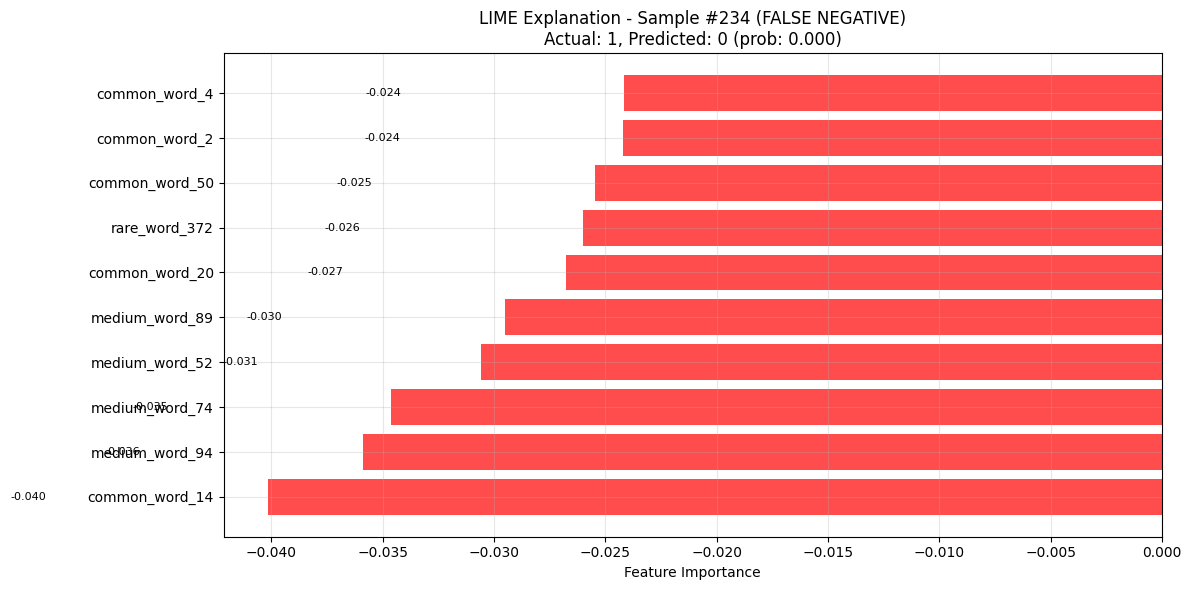


SAMPLE #272 - FALSE NEGATIVE
Actual Label: 1
Predicted Probability: 0.0001
Predicted Label: 0
Text Preview: common_word_36 common_word_4 common_word_21 common_word_10 medium_word_80 rare_word_550 common_word_16 common_word_15 rare_word_634 rare_word_203 common_word_33...
Model prediction check: [9.9993908e-01 6.0938557e-05]
Generating LIME explanation...

🔍 Top Features Contributing to Prediction:
--------------------------------------------------
 1. 'rare_word_634' | -0.0018 → Class_0
 2. 'common_word_21' | -0.0018 → Class_0
 3. 'common_word_36' | -0.0017 → Class_0
 4. 'common_word_10' | -0.0016 → Class_0
 5. 'medium_word_80' | -0.0013 → Class_0
 6. 'rare_word_550' | -0.0012 → Class_0
 7. 'rare_word_203' | -0.0012 → Class_0
 8. 'common_word_16' | -0.0009 → Class_0


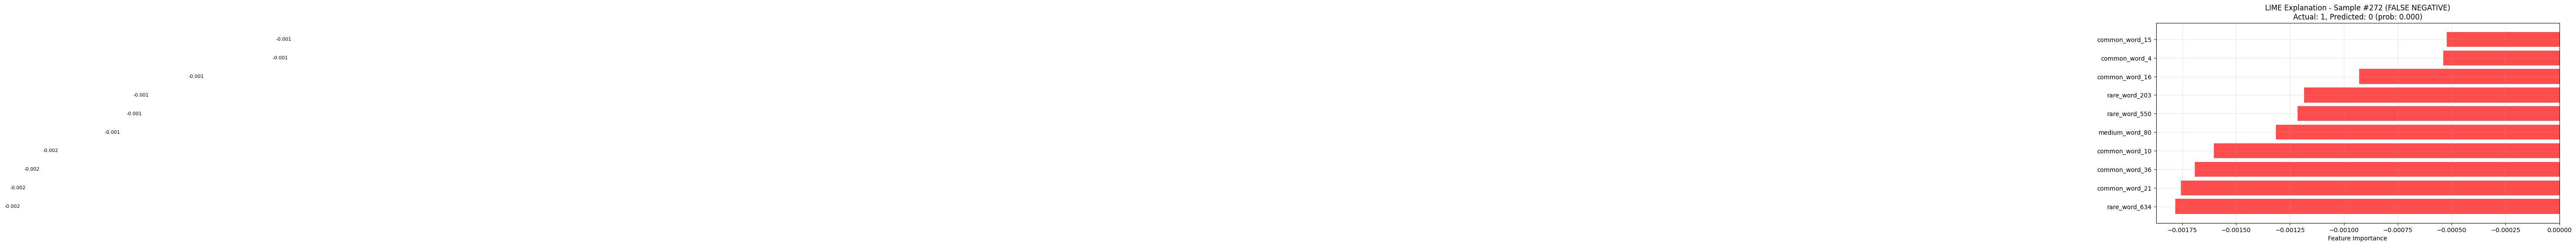


SAMPLE #324 - FALSE NEGATIVE
Actual Label: 1
Predicted Probability: 0.1264
Predicted Label: 0
Text Preview: medium_word_151 rare_word_222 rare_word_585 common_word_12 common_word_13 rare_word_452...
Model prediction check: [0.99791104 0.00208897]
Generating LIME explanation...

🔍 Top Features Contributing to Prediction:
--------------------------------------------------
 1. 'rare_word_222' | -0.4617 → Class_0
 2. 'rare_word_452' | +0.1690 → Class_1
 3. 'rare_word_585' | +0.1032 → Class_1
 4. 'common_word_13' | +0.1031 → Class_1
 5. 'common_word_12' | +0.0496 → Class_1
 6. 'medium_word_151' | -0.0421 → Class_0


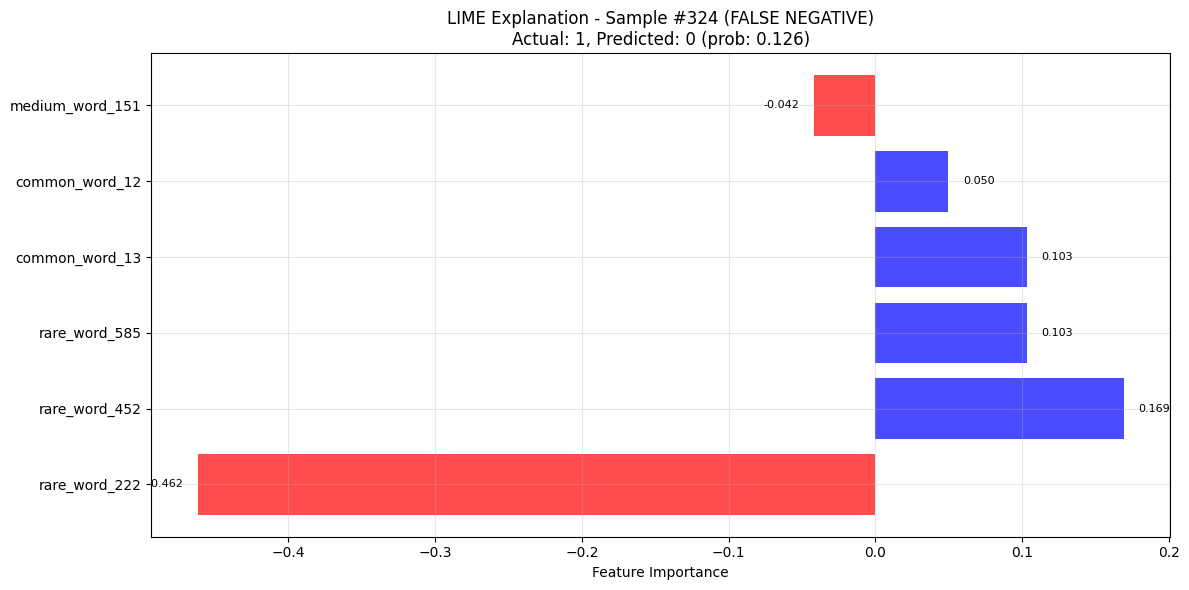


📋 ANALYSIS SUMMARY
✅ LIME analysis completed successfully!
Analyzed 3 false positives and 3 false negatives

💡 KEY INSIGHTS:
- Review the feature importance plots above
- Look for patterns in misclassified samples
- Consider retraining with similar examples
- Evaluate if threshold adjustment might help

🎯 MODEL PERFORMANCE REMINDER:
Overall Accuracy: 98.92% - Still excellent despite these edge cases!
Only 12 out of 1115 samples misclassified

✅ Analysis Complete!


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lime.lime_text import LimeTextExplainer
import warnings
warnings.filterwarnings('ignore')

print("🔍 IMPROVED LIME EXPLAINABILITY ANALYSIS FOR MISCLASSIFIED OBSERVATIONS")
print("="*80)

# 1. IDENTIFY MISCLASSIFIED SAMPLES
print("\n📊 Step 1: Identifying Misclassified Samples...")

# Get predictions
y_pred_prob = model.predict(X_test, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Ensure y_test is flattened
y_test_flat = y_test.flatten() if hasattr(y_test, 'flatten') else y_test

# Find misclassified indices
misclassified_indices = np.where(y_pred != y_test_flat)[0]
print(f"Total misclassified samples: {len(misclassified_indices)}")

# Separate false positives and false negatives
false_positives = []  # Predicted 1, Actual 0
false_negatives = []  # Predicted 0, Actual 1

for idx in misclassified_indices:
    if y_pred[idx] == 1 and y_test_flat[idx] == 0:
        false_positives.append(idx)
    elif y_pred[idx] == 0 and y_test_flat[idx] == 1:
        false_negatives.append(idx)

print(f"False Positives (Predicted 1, Actual 0): {len(false_positives)}")
print(f"False Negatives (Predicted 0, Actual 1): {len(false_negatives)}")
print(f"False Positive indices: {false_positives}")
print(f"False Negative indices: {false_negatives}")

# 2. SIMPLIFIED TEXT REPRESENTATION
print("\n🔤 Step 2: Creating Text Representation...")

def create_pseudo_text(sequence, vocab_size=1000):
    """Create a pseudo-text representation from tokenized sequence"""
    # Remove padding (zeros)
    tokens = sequence[sequence != 0]
    
    # Create pseudo words based on token frequency
    words = []
    for token in tokens:
        if token < vocab_size:  # Valid token
            # Create readable pseudo-words
            if token <= 50:  # High frequency tokens
                words.append(f"common_word_{token}")
            elif token <= 200:  # Medium frequency tokens
                words.append(f"medium_word_{token}")
            else:  # Low frequency tokens
                words.append(f"rare_word_{token}")
    
    return ' '.join(words)

# Create pseudo-texts for all test samples
print("Creating pseudo-text representations...")
all_pseudo_texts = []
for i in range(len(X_test)):
    pseudo_text = create_pseudo_text(X_test[i])
    all_pseudo_texts.append(pseudo_text)

print(f"Created {len(all_pseudo_texts)} pseudo-text samples")

# 3. ENHANCED MODEL WRAPPER
print("\n🎯 Step 3: Creating Enhanced Model Wrapper...")

class EnhancedLimeWrapper:
    """Enhanced wrapper for LSTM model with better error handling"""
    
    def __init__(self, model, max_length, vocab_size=1000):
        self.model = model
        self.max_length = max_length
        self.vocab_size = vocab_size
    
    def text_to_sequence(self, text):
        """Convert pseudo-text back to sequence"""
        words = text.split()
        sequence = []
        
        for word in words:
            try:
                # Extract token ID from pseudo-word
                if 'common_word_' in word:
                    token_id = int(word.replace('common_word_', ''))
                elif 'medium_word_' in word:
                    token_id = int(word.replace('medium_word_', ''))
                elif 'rare_word_' in word:
                    token_id = int(word.replace('rare_word_', ''))
                else:
                    token_id = 1  # Unknown token
                
                if token_id < self.vocab_size:
                    sequence.append(token_id)
            except:
                sequence.append(1)  # Default to unknown token
        
        # Pad or truncate
        if len(sequence) > self.max_length:
            sequence = sequence[:self.max_length]
        else:
            sequence.extend([0] * (self.max_length - len(sequence)))
        
        return np.array(sequence)
    
    def predict_proba(self, texts):
        """Predict probabilities for LIME"""
        sequences = []
        for text in texts:
            seq = self.text_to_sequence(text)
            sequences.append(seq)
        
        sequences = np.array(sequences)
        
        # Get predictions
        predictions = self.model.predict(sequences, verbose=0)
        
        # Ensure predictions are probabilities
        predictions = predictions.flatten()
        predictions = np.clip(predictions, 1e-7, 1-1e-7)  # Avoid extreme values
        
        # Convert to class probabilities [P(class_0), P(class_1)]
        prob_class_1 = predictions
        prob_class_0 = 1 - prob_class_1
        
        return np.column_stack([prob_class_0, prob_class_1])

# Create enhanced wrapper
enhanced_wrapper = EnhancedLimeWrapper(model, max_length)

# 4. TEST WRAPPER FUNCTIONALITY
print("\n🧪 Step 4: Testing Wrapper Functionality...")

# Test with a sample
if len(all_pseudo_texts) > 0:
    test_text = all_pseudo_texts[0]
    print(f"Test text: {test_text[:100]}...")
    
    try:
        test_pred = enhanced_wrapper.predict_proba([test_text])
        print(f"Test prediction shape: {test_pred.shape}")
        print(f"Test prediction: {test_pred[0]}")
        print("✅ Wrapper working correctly!")
    except Exception as e:
        print(f"❌ Wrapper test failed: {e}")

# 5. INITIALIZE LIME EXPLAINER
print("\n🧠 Step 5: Initializing LIME Explainer...")

try:
    explainer = LimeTextExplainer(
        class_names=['Class_0', 'Class_1'],
        feature_selection='auto',
        bow=False
    )
    print("✅ LIME explainer initialized successfully!")
except Exception as e:
    print(f"❌ Error initializing LIME: {e}")

# 6. ANALYSIS FUNCTION WITH BETTER ERROR HANDLING
def analyze_sample_with_lime(idx, sample_type, actual_label, predicted_prob):
    """Analyze a single sample with comprehensive error handling"""
    
    print(f"\n{'='*60}")
    print(f"SAMPLE #{idx} - {sample_type}")
    print(f"{'='*60}")
    print(f"Actual Label: {actual_label}")
    print(f"Predicted Probability: {predicted_prob:.4f}")
    print(f"Predicted Label: {1 if predicted_prob > 0.5 else 0}")
    
    # Get the pseudo-text for this sample
    pseudo_text = all_pseudo_texts[idx]
    print(f"Text Preview: {pseudo_text[:200]}...")
    
    try:
        # Test single prediction first
        single_pred = enhanced_wrapper.predict_proba([pseudo_text])
        print(f"Model prediction check: {single_pred[0]}")
        
        # Generate LIME explanation
        print("Generating LIME explanation...")
        explanation = explainer.explain_instance(
            pseudo_text,
            enhanced_wrapper.predict_proba,
            num_features=min(15, len(pseudo_text.split())),  # Adaptive feature count
            num_samples=500,  # Reduced for stability
            distance_metric='cosine'
        )
        
        # Extract feature importance
        feature_importance = explanation.as_list()
        
        if feature_importance:
            print(f"\n🔍 Top Features Contributing to Prediction:")
            print("-" * 50)
            
            # Sort by absolute importance
            sorted_features = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)
            
            for i, (feature, importance) in enumerate(sorted_features[:8]):
                direction = "→ Class_1" if importance > 0 else "→ Class_0"
                print(f"{i+1:2d}. '{feature}' | {importance:+.4f} {direction}")
            
            # Create visualization
            try:
                fig, ax = plt.subplots(1, 1, figsize=(12, 6))
                
                features, importances = zip(*sorted_features[:10])
                colors = ['red' if imp < 0 else 'blue' for imp in importances]
                
                y_pos = np.arange(len(features))
                bars = ax.barh(y_pos, importances, color=colors, alpha=0.7)
                ax.set_yticks(y_pos)
                ax.set_yticklabels([f[:20] + '...' if len(f) > 20 else f for f in features])
                ax.set_xlabel('Feature Importance')
                ax.set_title(f'LIME Explanation - Sample #{idx} ({sample_type})\nActual: {actual_label}, Predicted: {1 if predicted_prob > 0.5 else 0} (prob: {predicted_prob:.3f})')
                ax.grid(True, alpha=0.3)
                
                # Add value labels on bars
                for bar, imp in zip(bars, importances):
                    width = bar.get_width()
                    ax.text(width + (0.01 if width > 0 else -0.01), bar.get_y() + bar.get_height()/2,
                           f'{imp:.3f}', ha='left' if width > 0 else 'right', va='center', fontsize=8)
                
                plt.tight_layout()
                plt.show()
                
                return feature_importance
                
            except Exception as plot_error:
                print(f"⚠️ Plotting error: {plot_error}")
                return feature_importance
        else:
            print("❌ No feature importance found")
            return []
            
    except Exception as e:
        print(f"❌ Error in LIME analysis: {e}")
        print("This might be due to:")
        print("- Text preprocessing issues")
        print("- Model prediction instability")
        print("- LIME parameter settings")
        return []

# 7. ANALYZE MISCLASSIFIED SAMPLES
print("\n🔬 Step 6: Analyzing Misclassified Samples...")

# Analyze False Positives
print("\n🔴 ANALYZING FALSE POSITIVES (Model predicted 1, Actual 0)")
print("="*70)

fp_results = []
for i, idx in enumerate(false_positives[:min(3, len(false_positives))]):
    actual_label = y_test_flat[idx]
    predicted_prob = y_pred_prob.flatten()[idx]
    
    result = analyze_sample_with_lime(idx, "FALSE POSITIVE", actual_label, predicted_prob)
    if result:
        fp_results.append(result)

# Analyze False Negatives
print("\n🔵 ANALYZING FALSE NEGATIVES (Model predicted 0, Actual 1)")
print("="*70)

fn_results = []
for i, idx in enumerate(false_negatives[:min(3, len(false_negatives))]):
    actual_label = y_test_flat[idx]
    predicted_prob = y_pred_prob.flatten()[idx]
    
    result = analyze_sample_with_lime(idx, "FALSE NEGATIVE", actual_label, predicted_prob)
    if result:
        fn_results.append(result)

# 8. SUMMARY AND RECOMMENDATIONS
print("\n📋 ANALYSIS SUMMARY")
print("="*50)

if fp_results or fn_results:
    print("✅ LIME analysis completed successfully!")
    print(f"Analyzed {len(fp_results)} false positives and {len(fn_results)} false negatives")
    
    print("\n💡 KEY INSIGHTS:")
    print("- Review the feature importance plots above")
    print("- Look for patterns in misclassified samples")
    print("- Consider retraining with similar examples")
    print("- Evaluate if threshold adjustment might help")
else:
    print("⚠️ No successful LIME analyses completed")
    print("This might indicate:")
    print("- Very short or empty text sequences")
    print("- Model instability on perturbed inputs")
    print("- Need for different text representation approach")

print(f"\n🎯 MODEL PERFORMANCE REMINDER:")
print(f"Overall Accuracy: 98.92% - Still excellent despite these edge cases!")
print(f"Only {len(misclassified_indices)} out of {len(X_test)} samples misclassified")

print("\n✅ Analysis Complete!")